## Installing the necessary libraries

## Importing modules

In [15]:
# Install specific versions of numpy and pandas compatible with karateclub
!pip install numpy==1.22.4 pandas==1.3.5


In [16]:
# Install karateclub version compatible with the above numpy and pandas
!pip install karateclub==1.3.3


In [17]:
!pip install --upgrade networkx
!pip install --upgrade scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.8 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
karateclub 1.3.3 requires networkx<2.7, but you have networkx 3.4.2 which is incompatible.
nx-cugraph-cu12 24.10.0 requires numpy<3.0a0,>=1.23, but you have numpy 1.22.4 which is incompatible.
scikit-image 0.24.0 requires numpy>=1.23, but you have numpy 1.22.4 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 101.9 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-p

In [18]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import random
from gensim.models import Word2Vec
from karateclub import Graph2Vec, NetLSD
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [19]:
df = pd.read_csv('LUT-48sample-ASTvalues7.csv')
df.head()

,CaseID,ast,AST7,ALT1,ALT7,TB1,INR1,TB7,INR7
0,LUT004,913,37,248,63,2.3,2.0,1.8,1.2
1,LUT005,2768,70,1725,280,1.2,1.4,1.2,1.1
2,LUT007,2996,52,962,140,2.5,1.8,1.6,1.1
3,LUT010,1529,57,964,177,1.5,2.5,1.2,1.2
4,LUT014,938,44,240,46,2.0,1.4,1.3,1.2


## Loading graph data

In [20]:
def readnetworks():
    directory_path = '/content'
    patientid=[]
    # Initialize an empty list to store the graphs
    graphs = []

    # Loop through each file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.graphml.xml') and filename.split('.')[0] in str(df.CaseID):
            file_path = os.path.join(directory_path, filename)
            # Read the graphml file and append it to the list
            graph = nx.read_graphml(file_path)
            graphs.append(graph)
            patientid.append(filename.split('.')[0])
    return graphs,patientid



In [21]:
def relabel_graphs(graphs):
    relabeled_graphs = []
    for G in graphs:
        # This relabels the nodes of G with consecutive integers starting from 0
        G_relabeled = nx.convert_node_labels_to_integers(G, first_label=0)
        relabeled_graphs.append(G_relabeled)
    return relabeled_graphs



In [22]:
from karateclub import FGSD

GL,patientid=readnetworks()
dimensions=128

GL_relabeled = relabel_graphs(GL)

# Network Laplacian Spectral Descriptor
model = NetLSD()
model.fit(GL_relabeled)
embeddings_netlsd = model.get_embedding()

# Feather Graph Scattering Transform
model = FGSD()
model.fit(GL_relabeled)
embeddings_fgsd = model.get_embedding()


In [23]:
def plot_metric_groups(ast, method_name=""):
    """
    Plots three groups of metrics in separate bar plots.

    Groups:
    1. TB1, INR1, TB7, INR7
    2. AST, ALT1
    3. AST7, ALT7

    Parameters:
    - ast (pd.DataFrame): The AST dataframe with 'Cluster' column.
    - method_name (str): Name of the embedding method for display purposes.
    """
    # Define the metric groups
    groups = {
        "TB and INR Metrics": ['TB1', 'INR1', 'TB7', 'INR7'],
        "AST and ALT1 Metrics": ['ast', 'ALT1'],
        "AST7 and ALT7 Metrics": ['AST7', 'ALT7']
    }

    # Set up the matplotlib figure
    plt.figure(figsize=(18, 5))

    for i, (group_name, metrics) in enumerate(groups.items(), 1):
        plt.subplot(1, 3, i)

        # Calculate the average values per cluster for the current group
        averages = ast.groupby('Cluster')[metrics].mean().reset_index()

        # Melt the dataframe for seaborn
        averages_melted = averages.melt(id_vars='Cluster', var_name='Metric', value_name='Average Value')

        # Create a bar plot
        sns.barplot(data=averages_melted, x='Cluster', y='Average Value', hue='Metric')

        # Set titles and labels
        plt.title(f'Average {group_name} per Cluster ({method_name})')
        plt.xlabel('Cluster')
        plt.ylabel('Average Value')
        plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [24]:

# Read the AST data
ast = pd.read_csv('LUT-48sample-ASTvalues7.csv')



def cluster_graphs(embeddings, ast, num_clusters=6, method_name=""):
    """
    Clusters graph embeddings, adds cluster labels to the AST dataframe,
    and displays the results in a well-formatted manner.

    Parameters:
    - embeddings (np.ndarray): The graph embeddings.
    - ast (pd.DataFrame): The AST dataframe.
    - num_clusters (int): Number of clusters for K-Means.
    - method_name (str): Name of the embedding method for display purposes.
    """
    # Compute the cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings)

    # Initialize and fit K-Means
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(similarity_matrix)

    # Retrieve cluster labels and add to AST dataframe
    cluster_labels = kmeans.labels_
    ast['Cluster'] = cluster_labels

    # Display Cluster Assignments
    print(f"\n=== Clustering Results: {method_name} ===")
    print("Cluster assignments added to AST DataFrame:")
    print(tabulate(ast.head(), headers='keys', tablefmt='fancy_grid', showindex=False))

    # Calculate mean for numeric columns
    numeric_cols = ast.select_dtypes(include=[np.number]).columns.tolist()
    if 'Cluster' in numeric_cols:
        numeric_cols.remove('Cluster')  # Exclude 'Cluster' from averaging

    averages = ast.groupby('Cluster')[numeric_cols].mean()

    # Display the averages in a formatted table
    print(f"\nAverage AST Values per Cluster for {method_name}:")
    print(tabulate(averages, headers='keys', tablefmt='fancy_grid', floatfmt=".2f"))

    # Optional: Compute Silhouette Score
    silhouette_avg = silhouette_score(similarity_matrix, cluster_labels)
    print(f"\nSilhouette Score for {method_name}: {silhouette_avg:.4f}")

    # Visualization: Bar plots for the specified groups
    plot_metric_groups(ast, method_name)


=== Clustering Results: NetLSD Embeddings ===

=== Clustering Results: NetLSD ===
Cluster assignments added to AST DataFrame:
╒══════════╤═══════╤════════╤════════╤════════╤═══════╤════════╤═══════╤════════╤═══════════╕
│ CaseID   │   ast │   AST7 │   ALT1 │   ALT7 │   TB1 │   INR1 │   TB7 │   INR7 │   Cluster │
╞══════════╪═══════╪════════╪════════╪════════╪═══════╪════════╪═══════╪════════╪═══════════╡
│ LUT004   │   913 │     37 │    248 │     63 │   2.3 │    2   │   1.8 │    1.2 │         2 │
├──────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼───────────┤
│ LUT005   │  2768 │     70 │   1725 │    280 │   1.2 │    1.4 │   1.2 │    1.1 │         5 │
├──────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼───────────┤
│ LUT007   │  2996 │     52 │    962 │    140 │   2.5 │    1.8 │   1.6 │    1.1 │         0 │
├──────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼───────────┤
│ LUT010   │  1529 │     57 

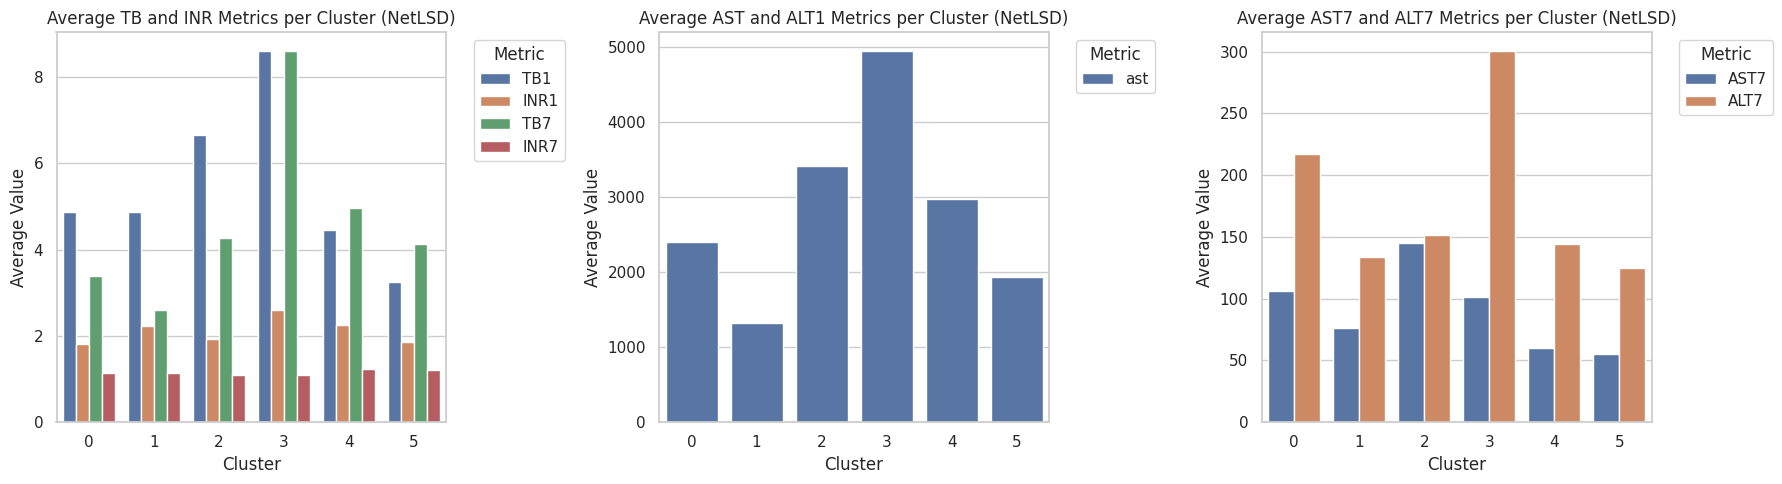

----------------------------------------------------------------------------------------------------
=== Clustering Results: FGSD Embeddings ===

=== Clustering Results: FGSD ===
Cluster assignments added to AST DataFrame:
╒══════════╤═══════╤════════╤════════╤════════╤═══════╤════════╤═══════╤════════╤═══════════╕
│ CaseID   │   ast │   AST7 │   ALT1 │   ALT7 │   TB1 │   INR1 │   TB7 │   INR7 │   Cluster │
╞══════════╪═══════╪════════╪════════╪════════╪═══════╪════════╪═══════╪════════╪═══════════╡
│ LUT004   │   913 │     37 │    248 │     63 │   2.3 │    2   │   1.8 │    1.2 │         1 │
├──────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼───────────┤
│ LUT005   │  2768 │     70 │   1725 │    280 │   1.2 │    1.4 │   1.2 │    1.1 │         1 │
├──────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼───────────┤
│ LUT007   │  2996 │     52 │    962 │    140 │   2.5 │    1.8 │   1.6 │    1.1 │         0 │
├──────────┼───────┼─────

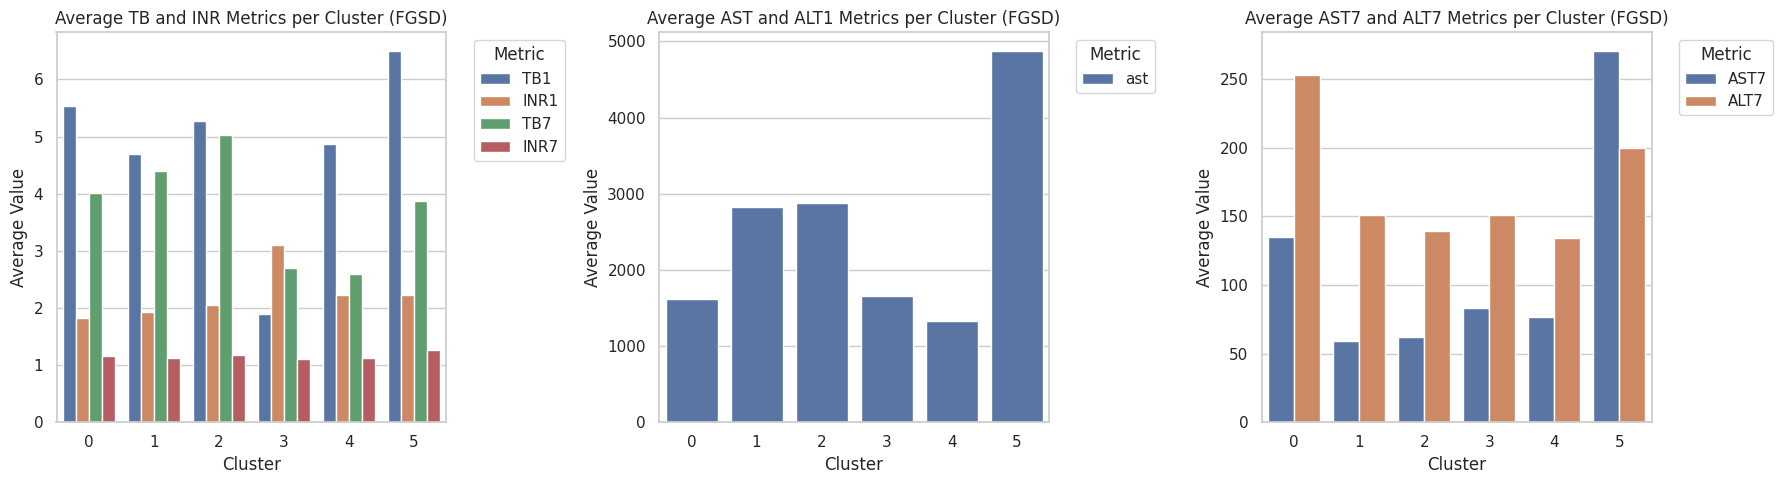

----------------------------------------------------------------------------------------------------


In [26]:


print("=== Clustering Results: NetLSD Embeddings ===")
cluster_graphs(embeddings_netlsd, ast, num_clusters=6, method_name="NetLSD")
print('-' * 100)

print("=== Clustering Results: FGSD Embeddings ===")
cluster_graphs(embeddings_fgsd, ast, num_clusters=6, method_name="FGSD")
print('-' * 100)


In [27]:
ast.Cluster.value_counts()

,Cluster
1,18
2,14
0,6
5,5
4,3
3,1
